In [112]:
using JuMP
using CSV
using LinearAlgebra
using DataFrames
using BARON
using Plots

In [2]:
A_db = CSV.File("./A_mat_new.csv",header=1,delim=",") |> DataFrame
B_db = CSV.File("./B_mat_new.csv",header=1,delim=",") |> DataFrame
f_db = CSV.File("./f_val_new.csv",header=1,delim=",") |> DataFrame
f_val=f_db[!,2]
A_mat=Matrix(A_db[:,2:size(A_db,2)])
B_mat=Matrix(B_db[:,2:size(B_db,2)])
nodes_val=names(A_db)[2:size(A_db,2)]
product_val=A_db[!,1]

30-element Vector{String63}:
 "Methanol "
 "Ethylene "
 "Propylene "
 "Toluene "
 "Benzene "
 "Xylene "
 "Butene "
 "Propane "
 "Syngas"
 "Urea "
 "Acrylonitrile"
 "Cyclohexane "
 "Caprolactam "
 ⋮
 "Vinyl chloride Monomer "
 "Polypropylene "
 "Styrene "
 "Ethylene glycol "
 "Terephthalic Acid (PTA) "
 "Polyethylene Terephthalate (PET)"
 "Propylene Oxide "
 "Butadiene "
 "Acetic Acid "
 "Formaldehyde "
 "Adipic Acid"
 "Gasoline Additives"

In [3]:
B_db

,Column1,Syngas Production,Methanol Manufacture,Steam Cracker,Hydrodealkylation (THD)
,String31,Float64,Float64,Float64,Float64
1,Coal,-55.6882,-25.4601,0.0,0.0
2,Natural Gas,-52.8947,-24.0426,-62.8951,0.0
3,Waste,20.7175,11.981,15.6427,0.251672
4,Environment,31.7886,13.2328,0.0,0.942308
5,Oil,0.0,-6.29662,-241.801,0.0
6,Limestone,0.0,0.0,0.0,0.0
7,Coal Energy,-59.4291,-18.6662,-87.5141,-0.584625
8,NG Energy,-31.7968,-9.98711,0.0,-0.312796
9,Environment Energy,91.2258,28.6533,87.5141,0.897421


In [42]:
function opt_decarb_base()
    dcrb =  Model(BARON.Optimizer)
    @variable(dcrb, 1 ≥ s[j=1:size(A_mat,2)] ≥ 0)
    @variable(dcrb,f[i=1:size(A_mat,1)] ≥ 0 )
    @variable(dcrb,g[k=1:size(B_mat,1)])
    @constraint(dcrb,[i=1:size(A_mat,1)],f[i] ≥ f_val[i])
    @constraint(dcrb,[i=1:size(A_mat,1)], f[i]==sum(A_mat[i,j]*s[j] for j in 1:size(A_mat,2)))
    @constraint(dcrb,[k=1:size(B_mat,1)],g[k]==sum(B_mat[k,j]*s[j] for j in 1:size(B_mat,2)))
    @variable(dcrb,obj)
    @constraint(dcrb,obj==sum(g[k] for k in 3:4)+g[9])
    @objective(dcrb,Min,obj)
    optimize!(dcrb)
    return JuMP.value.(s),JuMP.value.(f),JuMP.value.(obj)
end
    

opt_decarb_base (generic function with 1 method)

In [59]:
function opt_decarb_em()
    dcrb =  Model(BARON.Optimizer)
    @variable(dcrb,s[j=1:size(A_mat,2)] ≥ 0)
    @variable(dcrb,f[i=1:size(A_mat,1)] ≥ 0 )
    @variable(dcrb,g[k=1:size(B_mat,1)])
    @constraint(dcrb,[i=1:size(A_mat,1)],f[i] ≥ f_val[i])
    @constraint(dcrb,[i=1:size(A_mat,1)], f[i]==sum(A_mat[i,j]*s[j] for j in 1:size(A_mat,2)))
    @constraint(dcrb,[k=1:size(B_mat,1)],g[k]==sum(B_mat[k,j]*s[j] for j in 1:size(B_mat,2)))
    @variable(dcrb,obj)
    @constraint(dcrb,obj==sum(g[k] for k in 3:4)+g[9])
    @objective(dcrb,Min,obj)
    optimize!(dcrb)
    return JuMP.value.(s),JuMP.value.(f),JuMP.value.(obj),JuMP.value.(g)
end
    

opt_decarb_em (generic function with 1 method)

In [60]:
function opt_decarb_ruse()
    dcrb =  Model(BARON.Optimizer)
    @variable(dcrb,s[j=1:size(A_mat,2)] ≥ 0)
    @variable(dcrb,f[i=1:size(A_mat,1)] ≥ 0 )
    @variable(dcrb,g[k=1:size(B_mat,1)])
    @constraint(dcrb,[i=1:size(A_mat,1)],f[i] ≥ f_val[i])
    @constraint(dcrb,[i=1:size(A_mat,1)], f[i]==sum(A_mat[i,j]*s[j] for j in 1:size(A_mat,2)))
    @constraint(dcrb,[k=1:size(B_mat,1)],g[k]==sum(B_mat[k,j]*s[j] for j in 1:size(B_mat,2)))
    @variable(dcrb,obj)
    @constraint(dcrb,obj==-1*(sum(g[k] for k in 1:2)+sum(g[5:8])))
    @objective(dcrb,Min,obj)
    optimize!(dcrb)
    return JuMP.value.(s),JuMP.value.(f),JuMP.value.(obj),JuMP.value.(g)
end

opt_decarb_ruse (generic function with 1 method)

In [163]:
function opt_decarb_eps(lb,ub,ep)
    dcrb =  Model(BARON.Optimizer)
    set_optimizer_attribute(dcrb,"PrLevel",0)
    @variable(dcrb,s[j=1:size(A_mat,2)] ≥ 0)
    @variable(dcrb,f[i=1:size(A_mat,1)] ≥ 0 )
    @variable(dcrb,g[k=1:size(B_mat,1)])
    @constraint(dcrb,[i=1:size(A_mat,1)],f[i] ≥ f_val[i])
    @constraint(dcrb,[i=1:size(A_mat,1)], f[i]==sum(A_mat[i,j]*s[j] for j in 1:size(A_mat,2)))
    @constraint(dcrb,[k=1:size(B_mat,1)],g[k]==sum(B_mat[k,j]*s[j] for j in 1:size(B_mat,2)))
    @variable(dcrb,obj)
    @constraint(dcrb,-1*(sum(g[k] for k in 1:2)+sum(g[5:8])) ≤ lb+(ub-lb)*ep)
    @constraint(dcrb,obj==sum(g[k] for k in 3:4)+g[9])
    @objective(dcrb,Min,obj)
    optimize!(dcrb)
    return JuMP.value.(s),JuMP.value.(f),JuMP.value.(obj),JuMP.value.(g)
end

opt_decarb_eps (generic function with 1 method)

In [164]:
s,f,obj_em,g_em=opt_decarb_em()

 BARON version 21.1.13. Built: LNX-64 Wed Jan 13 16:09:31 EST 2021

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Bhavik R. Bakshi at The Ohio State University, bakshi.2@osu.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Solving bounding LP
 Preprocessing found feasible solution with value  671.548713881     
 Problem solved during preprocessing
 Lower bound is  671.548713881     

 Calculating duals

                         *** Normal completion ***            

 Wall clock time:                     0.01
 Total CPU time used:             

([0.9999999999999032, 1.0, 1.0090556646688351, 0.9362144182838765, 1.0695784630053466, 1.9580893215458828, 0.0, 1.958089321545883, 1.0, 1.0  …  1.0000000000000002, 0.9999999999999998, 1.0, 1.0, 1.0, 1.0000000000000002, 1.0, 1.0, 1.0000000000000002, 1.0], [25.891018048, 40.254667052, 0.754126315000008, 42.891233347, 10.572503059, 13.33125330109294, 0.0, 12.02323806009816, 0.0, 43.6  …  14.67692308, 6.520258063, 9.33513253, 41.93128333, 6.951724138000001, 19.965538247645146, 7.2, 8.346, 1.9232876710000002, 209.1198411], 671.5487138813737, [-81.14824449997654, -146.4135610195298, 79.87458102267179, 45.90356892769774, -583.3512396536383, 0.0, -390.53994499432605, -155.23061892567816, 545.7705639310042])

In [165]:
s,f,obj_ru,g_ru=opt_decarb_ruse()

 BARON version 21.1.13. Built: LNX-64 Wed Jan 13 16:09:31 EST 2021

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Bhavik R. Bakshi at The Ohio State University, bakshi.2@osu.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Khajavirad, A. and N. V. Sahinidis,
 A hybrid LP/NLP paradigm for global optimization relaxations,
 Mathematical Programming Computation, 10, 383-421, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Solving bounding LP
 Preprocessing found feasible solution with value  1345.11906481     
 Problem solved during preprocessing
 Lower bound is  1345.11906481     

 Calculating duals

                         *** Normal completion ***            

 Wall clock time:                     0.01
 Total CPU time used:             

([0.9999999999999032, 1.0, 1.0, 1.000000000000002, 0.999999999999997, 1.0000000000000029, 1.000000000000003, 1.000000000000003, 1.0, 1.0  …  1.0000000000000002, 0.9999999999999998, 1.0, 1.0, 1.0, 1.0000000000000002, 1.0, 1.0, 1.0000000000000002, 1.0], [25.891018048, 40.254667052, 0.754126315000008, 42.891233347, 10.572503059, 12.947543133000002, 0.0, 0.0, 0.0, 43.6  …  14.67692308, 6.520258063, 9.33513253, 41.93128333, 6.951724138000001, 19.78635961, 7.2, 8.346, 1.9232876710000002, 209.1198411], 1345.119064812921, [-81.14824449997656, -142.90253010497779, 80.0093793529895, 45.96367457198753, -574.4710476749955, 0.0, -390.80225943098105, -155.79498310198986, 546.597242543971])

In [166]:
res_f=DataFrame(pdt=product_val, final_demand=f)
res_s=DataFrame(node=nodes_val, scaling_factor=s)

,node,scaling_factor
,String,Float64
1,Syngas Production,1.0
2,Methanol Manufacture,1.0
3,Steam Cracker,1.0
4,Hydrodealkylation (THD),1.0
5,Disproportionation (TDP),1.0
6,Metathesis,1.0
7,Dehydrogenation,1.0
8,Refinery,1.0
9,Urea Synthesis,1.0


In [167]:
ub_em=(sum(g_ru[3:4])+sum(g_ru[9:9]))
ub=-1*(sum(g_em[1:2])+sum(g_em[5:8]))
lb=obj_ru

e_vec=[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
eps_res=DataFrame(Emissions=[obj_em,ub_em], Resource_Use=[ub,lb])
for i in 1:size(e_vec,2)
    s,f,obj_eps,g_eps=opt_decarb_eps(lb,ub,e_vec[i])
    temp_ru=-1*(sum(g_eps[1:2])+sum(g_eps[5:8]))
    #eps_res=eps_res.append({'Emissions':obj_eps,'Resource_Use':temp_ru})
    push!(eps_res,[obj_eps, temp_ru])
end
eps_res

 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX lib

,Emissions,Resource_Use
,Float64,Float64
1,671.549,1356.68
2,672.57,1345.12
3,672.468,1346.28
4,672.366,1347.43
5,672.264,1348.59
6,672.162,1349.74
7,672.06,1350.9
8,671.957,1352.06
9,671.855,1353.21


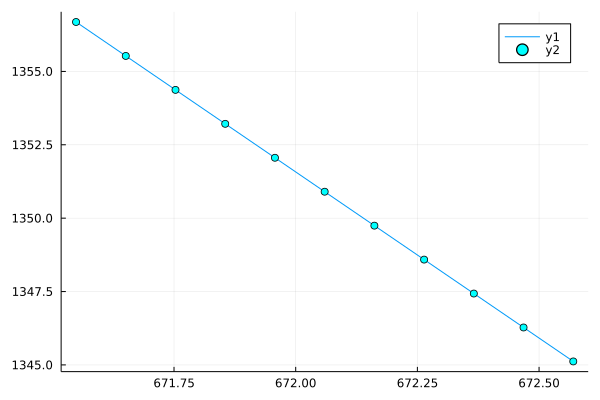

In [195]:
sort!(eps_res,:Emissions)
plot(eps_res[!,:Emissions],eps_res[!,:Resource_Use])
plot!(eps_res[!,:Emissions],eps_res[!,:Resource_Use], seriestype = :scatter, color="cyan")

In [169]:
eps_res

,Emissions,Resource_Use
,Float64,Float64
1,671.549,1356.68
2,671.651,1355.53
3,671.753,1354.37
4,671.855,1353.21
5,671.957,1352.06
6,672.06,1350.9
7,672.162,1349.74
8,672.264,1348.59
9,672.366,1347.43


## Sensitivity optimization

In [170]:
function sens_opt_decarb_em()
    dcrb =  Model(BARON.Optimizer)
    @variable(dcrb,s[j=1:size(A_mat,2)] ≥ 0)
    @variable(dcrb,f[i=1:size(A_mat,1)] ≥ 0 )
    @variable(dcrb,g[k=1:size(B_mat,1)])
    
    
    @variable(dcrb,y1[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,y2[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,y[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @constraint(dcrb,[i=1:size(A_mat,1),j=1:size(A_mat,2)],y[i,j] == y1[i,j]+y2[i,j])
    @constraint(dcrb,sum(y[i,j] for i in 1:size(A_mat,1), j=1:size(A_mat,2)) ≤ 10) 
    
    @constraint(dcrb,[i=1:size(A_mat,1)],f[i] ≥ f_val[i])
    @constraint(dcrb,[i=1:size(A_mat,1)], f[i]==sum(A_mat[i,j]*(1+0.1*y1[i,j]-0.1*y2[i,j])*s[j] for j in 1:size(A_mat,2)))
    @constraint(dcrb,[k=1:size(B_mat,1)],g[k]==sum(B_mat[k,j]*s[j] for j in 1:size(B_mat,2)))
    @variable(dcrb,obj)
    @constraint(dcrb,obj==sum(g[k] for k in 3:4)+g[9])
    @objective(dcrb,Min,obj)
    optimize!(dcrb)
    return JuMP.value.(s),JuMP.value.(f),JuMP.value.(obj),JuMP.value.(g),JuMP.value.(y1),JuMP.value.(y2)
end
    

sens_opt_decarb_em (generic function with 1 method)

In [171]:
function sens_opt_decarb_ru()
    dcrb =  Model(BARON.Optimizer)
    @variable(dcrb,s[j=1:size(A_mat,2)] ≥ 0)
    @variable(dcrb,f[i=1:size(A_mat,1)] ≥ 0 )
    @variable(dcrb,g[k=1:size(B_mat,1)])
    
    
    @variable(dcrb,y1[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,y2[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,y[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @constraint(dcrb,[i=1:size(A_mat,1),j=1:size(A_mat,2)],y[i,j] == y1[i,j]+y2[i,j])
    @constraint(dcrb,sum(y[i,j] for i in 1:size(A_mat,1), j=1:size(A_mat,2)) ≤ 10) 
    
    @constraint(dcrb,[i=1:size(A_mat,1)],f[i] ≥ f_val[i])
    @constraint(dcrb,[i=1:size(A_mat,1)], f[i]==sum(A_mat[i,j]*(1+0.1*y1[i,j]-0.1*y2[i,j])*s[j] for j in 1:size(A_mat,2)))
    @constraint(dcrb,[k=1:size(B_mat,1)],g[k]==sum(B_mat[k,j]*s[j] for j in 1:size(B_mat,2)))
    @variable(dcrb,obj)
    @constraint(dcrb,obj==-1*(sum(g[k] for k in 1:2)+sum(g[5:8])))
    @objective(dcrb,Min,obj)
    optimize!(dcrb)
    return JuMP.value.(s),JuMP.value.(f),JuMP.value.(obj),JuMP.value.(g),JuMP.value.(y1),JuMP.value.(y2)
end
    

sens_opt_decarb_ru (generic function with 1 method)

In [172]:
function sens_opt_decarb_eps(lb,ub,ep)
    dcrb =  Model(BARON.Optimizer)
    set_optimizer_attribute(dcrb,"PrLevel",0)
    @variable(dcrb,s[j=1:size(A_mat,2)] ≥ 0)
    @variable(dcrb,f[i=1:size(A_mat,1)] ≥ 0 )
    @variable(dcrb,g[k=1:size(B_mat,1)])
    
    
    @variable(dcrb,y1[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,y2[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @variable(dcrb,y[i=1:size(A_mat,1),j=1:size(A_mat,2)],Bin)
    @constraint(dcrb,[i=1:size(A_mat,1),j=1:size(A_mat,2)],y[i,j] == y1[i,j]+y2[i,j])
    @constraint(dcrb,sum(y[i,j] for i in 1:size(A_mat,1), j=1:size(A_mat,2)) ≤ 10) 
    
    @constraint(dcrb,[i=1:size(A_mat,1)],f[i] ≥ f_val[i])
    @constraint(dcrb,[i=1:size(A_mat,1)], f[i]==sum(A_mat[i,j]*(1+0.1*y1[i,j]-0.1*y2[i,j])*s[j] for j in 1:size(A_mat,2)))
    @constraint(dcrb,[k=1:size(B_mat,1)],g[k]==sum(B_mat[k,j]*s[j] for j in 1:size(B_mat,2)))
    @variable(dcrb,obj)
    @constraint(dcrb,-1*(sum(g[k] for k in 1:2)+sum(g[5:8])) ≤ lb+(ub-lb)*ep)
    @constraint(dcrb,obj==sum(g[k] for k in 3:4)+g[9])
    @objective(dcrb,Min,obj)
    optimize!(dcrb)
    return JuMP.value.(s),JuMP.value.(f),JuMP.value.(obj),JuMP.value.(g),JuMP.value.(y1),JuMP.value.(y2)
end
    

sens_opt_decarb_eps (generic function with 2 methods)

In [175]:
s,f,obj_em,g_em,y1,y2=sens_opt_decarb_em()

 BARON version 21.1.13. Built: LNX-64 Wed Jan 13 16:09:31 EST 2021

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Bhavik R. Bakshi at The Ohio State University, bakshi.2@osu.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Kilinc, M. and N. V. Sahinidis, Exploiting integrality in the global
 optimization of mixed-integer nonlinear programming problems in BARON,
 Optimization Methods and Software, 33, 540-562, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Doing local search
 Preprocessing found feasible solution with value  597.359644723     
 Solving bounding LP
 Starting multi-start local search
 Done with local search
  Iteration    Open nodes         Time (s)    Lower bound      Upper bound
*         1             1             1.89

([0.7526016289435181, 0.8879841577540107, 0.9113257882135315, 1.6061159879167946, 0.3465715670482331, 3.057922229234247, 0.0, 3.057922229234247, 0.9090909090909091, 1.0  …  1.0, 0.8597492981087163, 0.9274340909092365, 0.9090909090909091, 1.0, 1.0, 1.0, 0.9999999999999999, 1.0, 1.00192869860631], [25.891018048, 40.254667052, 0.754126315000008, 42.891233347, 10.572503059, 12.947543133, 0.0, 18.77653206459606, 0.0, 43.6  …  14.67692308, 6.520258063, 9.33513253, 41.93128333, 6.951724138, 19.835001744205595, 7.2, 8.346, 1.923287671, 209.52317024608138], 595.5249420877806, [-64.51914813519942, -127.86426974387184, 71.11094156793646, 37.188095242025625, -567.3110358997135, 0.0, -349.42811087544044, -137.7977943922808, 487.2259052778185], [0.0 1.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [176]:
print(" Positive perturbations \n\n")

for i in 1:size(findall(x->x==1, y1),1)
    print(nodes_val[findall(x->x==1, y1)[i][2]]*" ---- "*product_val[findall(x->x==1, y1)[i][1]]*"\n")
end   
print("\n Negative perturbations \n\n")
for i in 1:size(findall(x->x==1, y2),1)
    print(nodes_val[findall(x->x==1, y2)[i][2]]*" ---- "*product_val[findall(x->x==1, y2)[i][1]]*"\n")
end   

 Positive perturbations 

Methanol Manufacture ---- Methanol 
Steam Cracker ---- Ethylene 
Steam Cracker ---- Butadiene 
Urea Synthesis ---- Urea 
EG Production ---- Ethylene glycol 
PET Production ---- Polyethylene Terephthalate (PET)

 Negative perturbations 

Methanol Manufacture ---- Syngas
Urea Synthesis ---- Syngas
Formaldehyde production ---- Methanol 


In [190]:

per_em=""
for i in 1:size(findall(x->x==1, y1),1)
    pos_em=nodes_val[findall(x->x==1, y1)[i][2]]*" ---- "*product_val[findall(x->x==1, y1)[i][1]]*"\n"
    per_em=per_em*pos_em
end   
per_em=per_em*"\n\n"
for i in 1:size(findall(x->x==1, y2),1)
    neg_em=nodes_val[findall(x->x==1, y2)[i][2]]*" ---- "*product_val[findall(x->x==1, y2)[i][1]]*"\n"
    per_em=per_em*neg_em
end  
per_em=replace(per_em,"\n"=>" | ")
print("\n")

In [191]:
s,f,obj_ru,g_ru,y1,y2=sens_opt_decarb_ru()

 BARON version 21.1.13. Built: LNX-64 Wed Jan 13 16:09:31 EST 2021

 BARON is a product of The Optimization Firm.
 For information on BARON, see https://minlp.com/about-baron
 Licensee: Bhavik R. Bakshi at The Ohio State University, bakshi.2@osu.edu.

 If you use this software, please cite publications from
 https://minlp.com/baron-publications, such as: 

 Kilinc, M. and N. V. Sahinidis, Exploiting integrality in the global
 optimization of mixed-integer nonlinear programming problems in BARON,
 Optimization Methods and Software, 33, 540-562, 2018.
 This BARON run may utilize the following subsolver(s)
 For LP/MIP/QP: CLP/CBC                                         
 For NLP: IPOPT, FILTERSD, FILTERSQP
 Doing local search
 Preprocessing found feasible solution with value  1268.11783715     
 Solving bounding LP
 Starting multi-start local search
 Done with local search
  Iteration    Open nodes         Time (s)    Lower bound      Upper bound
*         1             1             2.08

([0.766257817873317, 0.9090909090909092, 0.9131669527684222, 1.9466870238611387, 0.05583963216006455, 1.4743699629825955, 1.4743699629825957, 1.4743699629825955, 0.9090909090909092, 1.0  …  1.0, 0.9999999999999999, 1.0000000000000002, 1.0, 1.0, 1.0, 1.0, 0.9999999999999998, 1.0, 0.9120689029035804], [25.891018048, 40.254667052, 0.7541263150000079, 42.891233347, 10.572503058999999, 12.947543133, 0.0, 0.0, 0.0, 43.6  …  14.67692308, 6.520258062999999, 9.33513253, 41.93128333, 6.951724138, 19.875074682588277, 7.2, 8.346, 1.923287671, 209.8048744521929], 1208.874985862631, [-65.81701565009274, -124.3481344367868, 73.40324359624506, 38.22242981270875, -528.1305915398124, 0.0, -351.289730706093, -139.2895135298463, 490.57924424621217], [0.0 1.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 1.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [189]:
print(" Positive perturbations \n\n")
per_ru=""
for i in 1:size(findall(x->x==1, y1),1)
    pos_ru=nodes_val[findall(x->x==1, y1)[i][2]]*" ---- "*product_val[findall(x->x==1, y1)[i][1]]*"\n"
    print(pos_ru)
    per_ru=per_ru*pos_ru
end   
print("\n\n Negative perturbations \n\n")
per_ru=per_ru*"\n\n"
for i in 1:size(findall(x->x==1, y2),1)
    neg_ru=nodes_val[findall(x->x==1, y2)[i][2]]*" ---- "*product_val[findall(x->x==1, y2)[i][1]]*"\n"
    print(neg_ru)
    per_ru=per_ru*neg_ru
end  
per_ru=replace(per_ru,"\n"=>" | ")
print("\n")

 Positive perturbations 

Syngas Production ---- Syngas
Methanol Manufacture ---- Methanol 
Steam Cracker ---- Ethylene 
Steam Cracker ---- Butadiene 
Urea Synthesis ---- Urea 
Catalytic Reformer ---- Toluene 
Catalytic Reformer ---- Xylene 
Catalytic Reformer ---- Gasoline Additives


 Negative perturbations 

Urea Synthesis ---- Syngas
PTA Production ---- Xylene 



In [192]:
function get_per_str(y1,y2)
    per_em=""
    for i in 1:size(findall(x->x==1, y1),1)
        pos_em=nodes_val[findall(x->x==1, y1)[i][2]]*" ---- "*product_val[findall(x->x==1, y1)[i][1]]*"\n"
        per_em=per_em*pos_em
    end   
    per_em=per_em*"\n\n"
    for i in 1:size(findall(x->x==1, y2),1)
        neg_em=nodes_val[findall(x->x==1, y2)[i][2]]*" ---- "*product_val[findall(x->x==1, y2)[i][1]]*"\n"
        per_em=per_em*neg_em
    end  
    per_em=replace(per_em,"\n"=>" | ")
    print("\n")
    return per_em
end


get_per_str (generic function with 1 method)

In [193]:
ub_em=(sum(g_ru[3:4])+sum(g_ru[9:9]))
ub=-1*(sum(g_em[1:2])+sum(g_em[5:8]))
lb=obj_ru

e_vec=[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
eps_res_sens=DataFrame(Emissions=[obj_em,ub_em], Resource_Use=[ub,lb], Perturbations=[per_em,per_ru])
for i in 1:size(e_vec,2)
    s,f,obj_eps,g_eps,y1,y2=sens_opt_decarb_eps(lb,ub,e_vec[i])
    temp_ru=-1*(sum(g_eps[1:2])+sum(g_eps[5:8]))
    #eps_res=eps_res.append({'Emissions':obj_eps,'Resource_Use':temp_ru})
    push!(eps_res_sens,[obj_eps, temp_ru,get_per_str(y1,y2)])
end

 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory

 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory

 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory

 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX library libcplex2010.so: cannot open shared object file: No such file or directory

 Unable to find/load CPLEX library libcplex.so: cannot open shared object file: No such file or directory
 Unable to find/load CPLEX

,Emissions,Resource_Use
,Float64,Float64
1,671.549,1356.68
2,671.651,1355.53
3,671.753,1354.37
4,671.855,1353.21
5,671.957,1352.06
6,672.06,1350.9
7,672.162,1349.74
8,672.264,1348.59
9,672.366,1347.43


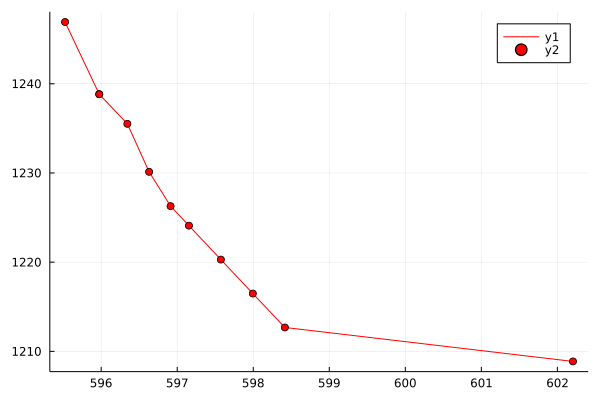

In [196]:
sort!(eps_res_sens,:Emissions)
plot(eps_res_sens[!,:Emissions],eps_res_sens[!,:Resource_Use],color="red")
plot!(eps_res_sens[!,:Emissions],eps_res_sens[!,:Resource_Use], seriestype = :scatter, color="red")

In [197]:
eps_res_sens

,Emissions,Resource_Use,Perturbations
,Float64,Float64,String
1,595.525,1246.92,Syngas Production ---- Syngas | Methanol Manufacture ---- Methanol | Steam Cracker ---- Ethylene | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | Catalytic Reformer ---- Toluene | Catalytic Reformer ---- Xylene | Catalytic Reformer ---- Gasoline Additives | | | Urea Synthesis ---- Syngas | PTA Production ---- Xylene |
2,595.975,1238.82,Syngas Production ---- Syngas | Steam Cracker ---- Ethylene | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | PP Manufacture ---- Polypropylene | PET Production ---- Polyethylene Terephthalate (PET) | | | Urea Synthesis ---- Syngas | Formaldehyde production ---- Methanol |
3,595.975,1238.82,Syngas Production ---- Syngas | Methanol Manufacture ---- Methanol | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | PP Manufacture ---- Polypropylene | PET Production ---- Polyethylene Terephthalate (PET) | | | Methanol Manufacture ---- Syngas | Urea Synthesis ---- Syngas | Formaldehyde production ---- Methanol |
4,596.344,1235.51,Syngas Production ---- Syngas | Methanol Manufacture ---- Methanol | Steam Cracker ---- Ethylene | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | PP Manufacture ---- Polypropylene | PET Production ---- Polyethylene Terephthalate (PET) | | | Methanol Manufacture ---- Syngas | Urea Synthesis ---- Syngas | Formaldehyde production ---- Methanol |
5,596.63,1230.13,Syngas Production ---- Syngas | Methanol Manufacture ---- Methanol | Steam Cracker ---- Ethylene | Steam Cracker ---- Propylene | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | PP Manufacture ---- Polypropylene | PET Production ---- Polyethylene Terephthalate (PET) | | | Methanol Manufacture ---- Syngas | Urea Synthesis ---- Syngas |
6,596.913,1226.28,Syngas Production ---- Syngas | Methanol Manufacture ---- Methanol | Steam Cracker ---- Ethylene | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | PTA Production ---- Terephthalic Acid (PTA) | PET Production ---- Polyethylene Terephthalate (PET) | Catalytic Reformer ---- Toluene | Catalytic Reformer ---- Gasoline Additives | | | Urea Synthesis ---- Syngas |
7,597.154,1224.09,Syngas Production ---- Syngas | Methanol Manufacture ---- Methanol | Steam Cracker ---- Ethylene | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | PTA Production ---- Terephthalic Acid (PTA) | PET Production ---- Polyethylene Terephthalate (PET) | Catalytic Reformer ---- Toluene | Catalytic Reformer ---- Gasoline Additives | | | Urea Synthesis ---- Syngas |
8,597.574,1220.29,Syngas Production ---- Syngas | Methanol Manufacture ---- Methanol | Steam Cracker ---- Ethylene | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | PTA Production ---- Terephthalic Acid (PTA) | PET Production ---- Polyethylene Terephthalate (PET) | | | Urea Synthesis ---- Syngas |
9,597.995,1216.48,Syngas Production ---- Syngas | Methanol Manufacture ---- Methanol | Steam Cracker ---- Ethylene | Steam Cracker ---- Butadiene | Urea Synthesis ---- Urea | PTA Production ---- Terephthalic Acid (PTA) | PET Production ---- Polyethylene Terephthalate (PET) | Catalytic Reformer ---- Toluene | Catalytic Reformer ---- Gasoline Additives | | | Urea Synthesis ---- Syngas |
